In [4]:
from __future__ import annotations

import logging
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


In [5]:
subjects = {
    "Биология": "biology",
    "Физика": "physics",
    "Математика": "math",
    "Информатика": "informatics",
    "Религиоведение": "religion",
    "Английский": "english",
    "Программирование": "programming",
    "История": "history",
    "Литература": "literature",
    "География": "geography",
    "Введение в геометрию": "intro-geometry",
    "Музыка": "music",
    "Физическая культура": "physical-culture",
    "Русский язык": "russian",
    "Обществознание": "sociology",
    "Алгебра": "algebra",
    "Введение в химию": "intro-chemistry",
    "Вероятность и статистика": "statistics",
    "Геометрия": "geometry",
    "Немецкий язык": "german",
}

trimesters = {
    "III триместр": "3",
    "II триместр": "2",
    "I триместр": "1",
}

In [6]:
def get_new_name(name: str) -> dict[str, str]:
    """Rename a table name to be more readable.

    Args:
        name (str): The name of the table.

    Returns:
        dict[str, str]: A dictionary containing the new name for each column.s

    """
    _, year, grade, subject, trimester = name.split("_")
    return {
        "year": year,
        "grade": grade,
        "subject": subjects[subject],
        "trimester": trimesters.get(trimester),
    }


# Rename tables
dir_name = pathlib.Path("data")

for file in dir_name.iterdir():
    suffix = file.suffix
    name = file.stem

    new_name_dict = get_new_name(name)
    new_name_dict["suffix"] = suffix

    new_name = "{year}_{grade}_{subject}_{trimester}{suffix}".format(
        **new_name_dict,
    )

    new_file = file.with_name(new_name)
    file.rename(new_file)

    logger.info("Renamed %s to %s", file, new_file)

In [ ]:
def process_dataframe(df: pd.DataFrame, table_name: str) -> pd.DataFrame:
    """Process a dataframe and returns a processed dataframe.

    Args:
        df (pd.DataFrame): The dataframe to be processed.
        table_name (str): The name of the table.

    Returns:
        pd.DataFrame: The processed dataframe.

    """
    student_ids: list[str] = []
    marks: list[int] = []

    marks_data: list[str] = []
    marks_weight: list[int] = []

    student_ids_column = df.iloc[3:, 0]

    df.iloc[3:, 0].dropna()

    for col in df.columns:
        mark_data = df[col][1]
        mark_weight = df[col][2]

        for i, val in enumerate(df[col][3:]):
            if type(val) in {int, float} and pd.notna(val):
                student_ids.append(student_ids_column[i + 3])
                marks.append(val)
                marks_data.append(mark_data)
                marks_weight.append(mark_weight)

    year, grade, subject, trimester = table_name.split("_")
    grade = grade.split("-")[0]

    result_df = pd.DataFrame(data={"student_id": student_ids, "mark": marks})
    result_df["grade"] = grade
    result_df["subject"] = subject
    result_df["trimester"] = trimester
    result_df["year"] = year
    result_df["marks_data"] = marks_data
    result_df["marks_weight"] = marks_weight

    return result_df.dropna(subset="student_id").reset_index(drop=True)

In [8]:
main_df = pd.DataFrame(
    columns=[
        "student_id",
        "mark",
        "grade",
        "subject",
        "trimester",
        "year",
        "marks_data",
        "marks_weight",
    ],
)

# Get all files in the directory and process them to a dataframe
for file in dir_name.iterdir():
    suffix = file.suffix
    name = file.stem

    dataframe = pd.read_excel(file)
    main_df = pd.concat(
        [main_df, process_dataframe(dataframe, name)],
        ignore_index=True,
    )

In [9]:
exclude_values = [
    "I", "II", "III", "Годовая", "Внутр. экз.",
]
main_df = main_df[~main_df["marks_data"].isin(exclude_values)]

In [10]:
import re

months = [
    "янв",
    "фев",
    "мар",
    "апр",
    "мая",
    "июн",
    "июл",
    "авг",
    "сен",
    "окт",
    "ноя",
    "дек",
]
months_dict = {month: i + 1 for i, month in enumerate(months)}


def get_date(str_date: str) -> tuple[int, int] | None:
    """Convert string date to tuple (int, int).

    Args:
        str_date (str): string date in format "ddmmm"

    Returns:
        tuple[int, int] | None: tuple (int, int) or None if string is not valid

    """
    re_match_number = re.match(r"\d+", str_date)
    if re_match_number is None:
        return None

    letter_match = re.search(r"[а-яА-Я]+", str_date)
    if letter_match is None:
        return None

    int_date_number = int(re_match_number.group())
    month = months_dict[letter_match.group()]
    return int_date_number, month


get_date("12дек")

(12, 12)

In [11]:
import datetime


def get_datetime_date(datetime_string: int, year: str) -> datetime.date | None:
    """Get the date from a datetime string and year.

    Args:
        datetime_string (int): The datetime string.
        year (str): The year.

    Returns:
        datetime.date | None: The date.

    """
    target_year: int
    begin_year, last_year = year.split("-")
    date_number, month = get_date(datetime_string)

    jan_int, dec_int, sep_int = 1, 12, 9
    if (month >= sep_int and month <= dec_int):
        target_year = int(begin_year)
    elif (month >= jan_int and month < sep_int):
        target_year = int(last_year)
    else:
        return None

    return datetime.date(target_year, month, date_number)


get_datetime_date(datetime_string="13дек", year="2022-2023")

datetime.date(2022, 12, 13)

In [12]:
main_df["mark_date"] = main_df.apply(
    lambda row: get_datetime_date(
        datetime_string=row["marks_data"],
        year=row["year"],
    ),
    axis=1,
)
main_df = main_df.drop(columns=["marks_data", "year"])

In [ ]:
main_df["student_id"] = main_df["student_id"].astype(str)
main_df["mark"] = main_df["mark"].astype(int)
main_df["grade"] = main_df["grade"].astype(int)
main_df["subject"] = main_df["subject"].astype(str)
main_df["trimester"] = main_df["trimester"].astype(int)
main_df["marks_weight"] = main_df["marks_weight"].astype(str)
main_df["mark_date"] = pd.to_datetime(main_df["mark_date"])

main_df = main_df.reset_index()
main_df = main_df.drop(columns=["index"])
main_df.head()

,student_id,mark,grade,subject,trimester,marks_weight,mark_date
0,Student_4430,60,7,physical-culture,1,ФРМ,2024-09-17
1,Student_3517,100,7,physical-culture,1,ФРМ,2024-09-17
2,Student_1093,100,7,physical-culture,1,ФРМ,2024-09-20
3,Student_2940,100,7,physical-culture,1,ФРМ,2024-09-20
4,Student_6300,100,7,physical-culture,1,ФРМ,2024-09-20


In [33]:
main_df = main_df[~main_df["marks_weight"].isin({"K1", "K2", "K3", "nan"})]

In [69]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10537 entries, 0 to 10587
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   student_id    10537 non-null  object        
 1   mark          10537 non-null  int64         
 2   grade         10537 non-null  int64         
 3   subject       10537 non-null  object        
 4   trimester     10537 non-null  int64         
 5   marks_weight  10537 non-null  object        
 6   mark_date     10537 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 658.6+ KB


In [74]:
custom_dark_bw_palette = [
    "#D0D0D0",
    "#A0A0A0",
    "#808080",
    "#606060",
    "#404040",
    "#303030",
    "#202020",
]

/tmp/ipykernel_110271/392227340.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="grade", y="mark", data=filtered_df, palette=custom_dark_bw_palette)
/tmp/ipykernel_110271/392227340.py:58: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.boxplot(x="grade", y="mark", data=filtered_df, palette=custom_dark_bw_palette)
/tmp/ipykernel_110271/392227340.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_110271/392227340.py:72: UserWarning: 
The palette list has fewer values (7) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


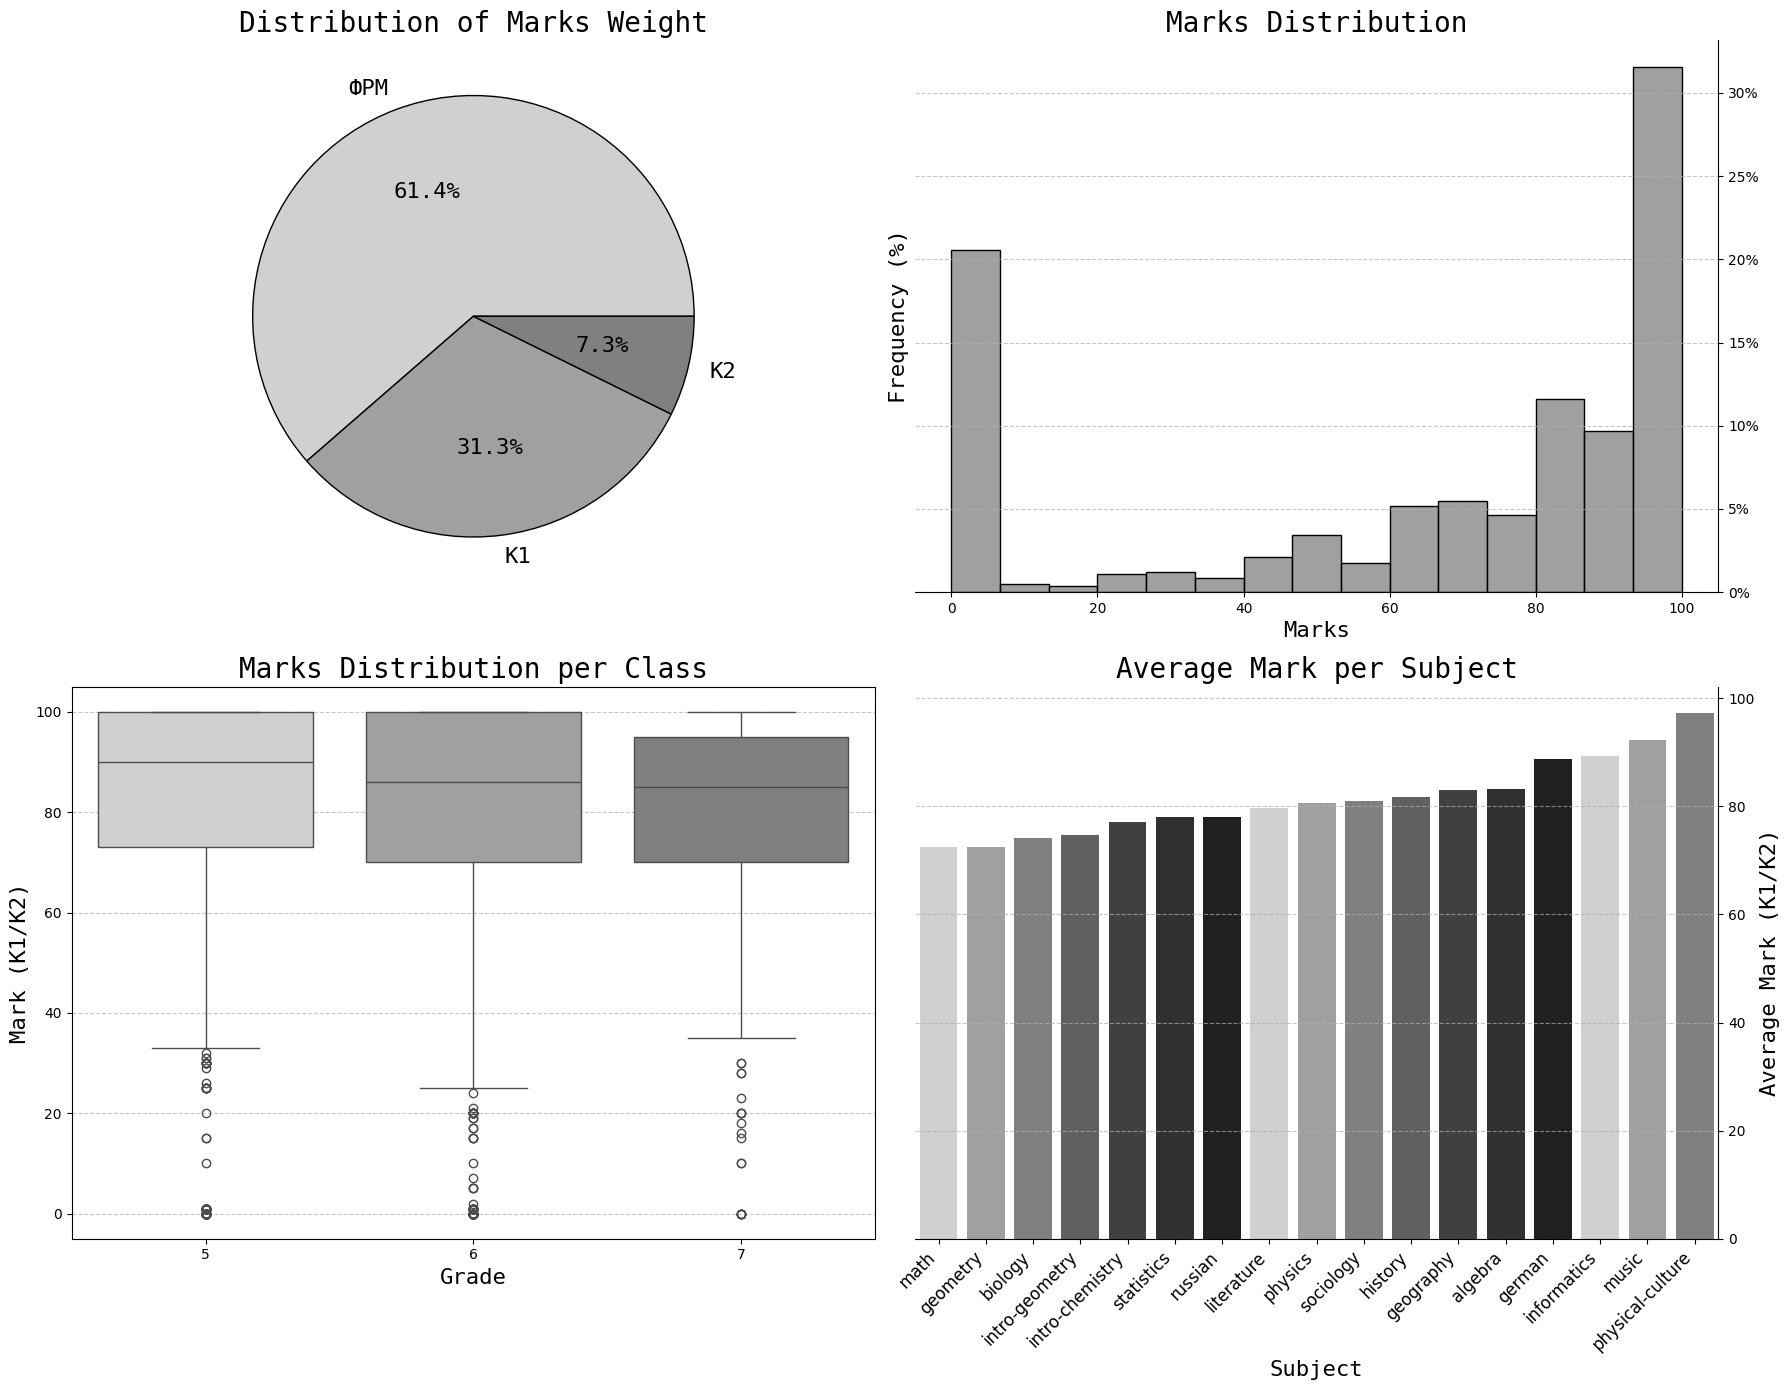

In [111]:
plt.figure(figsize=(18, 14))
plt.subplot(2, 2, 1)

marks_weight_counts = main_df["marks_weight"].value_counts()
sns.set_palette(custom_dark_bw_palette)

# Grouping values less than 1% into a single "Other" category
threshold = 0.01 * marks_weight_counts.sum()
marks_weight_grouped = marks_weight_counts.copy()
marks_weight_grouped["Other"] = marks_weight_grouped[
    marks_weight_grouped < threshold
].sum()
marks_weight_grouped = marks_weight_grouped[marks_weight_grouped >= threshold]

# Plotting the updated pie chart on the 'marks weight' column
plt.pie(
    marks_weight_grouped,
    labels=marks_weight_grouped.index,
    autopct="%1.1f%%",
    textprops={"color": "black", "fontfamily": "monospace", "fontsize": 16},
    wedgeprops={"edgecolor": "black", "linewidth": 1},
)
plt.title(
    "Distribution of Marks Weight",
    color="black",
    fontfamily="monospace",
    fontsize=20,
)

# Histogram of marks
plt.subplot(2, 2, 2)

sns.histplot(main_df["mark"], bins=15, kde=False, color="#808080", stat="percent")
plt.title("Marks Distribution", fontfamily="monospace", color="black", fontsize=20)
plt.xlabel("Marks", fontsize=16, fontfamily="monospace")
plt.ylabel("Frequency (%)", fontsize=16, fontfamily="monospace")

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))
plt.gca().yaxis.tick_right()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

# Necessary to make the plot...
class_counts = main_df["grade"].value_counts()
subject_avg_marks = (
    main_df[main_df["marks_weight"].isin({"К1", "К2"})]
    .groupby("subject")["mark"]
    .mean()
    .sort_values()
)

# Third Plot: Box plot for marks per class
plt.subplot(2, 2, 3)

filtered_df = main_df[main_df["marks_weight"].isin({"К1", "К2"})]
sns.boxplot(x="grade", y="mark", data=filtered_df, palette=custom_dark_bw_palette)

plt.title(
    "Marks Distribution per Class",
    fontfamily="monospace",
    color="black",
    fontsize=20,
)
plt.xlabel("Grade", fontfamily="monospace", fontsize=16)
plt.ylabel("Mark (К1/К2)", fontfamily="monospace", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Fourth Plot: Average mark per subject
plt.subplot(2, 2, 4)
sns.barplot(
    x=subject_avg_marks.index,
    y=subject_avg_marks.values,
    palette=custom_dark_bw_palette,
)
plt.title(
    "Average Mark per Subject",
    fontfamily="monospace",
    color="black",
    fontsize=20,
)
plt.xlabel("Subject", fontfamily="monospace", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.ylabel("Average Mark (К1/К2)", fontfamily="monospace", fontsize=16)

plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("figures/main.png", dpi=300)

In [ ]:
# Get the student IDs with the largest number of marks in math for the first year
main_df[
    (main_df["subject"] == "math")
    & (main_df["marks_weight"].isin({"К1", "К2"}))
].groupby("student_id")["mark"].agg(
    ["mean", "count"],
).sort_values(by="count", ascending=False)

,mean,count
student_id,,
Student_1047,83.614035,57
Student_8499,87.038462,52
Student_8787,89.784314,51
Student_1093,68.400000,50
Student_8008,88.820000,50
Student_6300,68.229167,48
Student_2940,64.340426,47
Student_9940,59.787234,47
Student_3275,71.760870,46


Так мы получили данные об оценках студентов по математике:
- Кол-во К1/К2 оценок
- Средний балл студента

Теперь посмотрим на то, как меняется балл у некоторых выборочных студентов в разных группах по величине среднего балла.
- Возьмем студента `Student_8787` с высоким средним баллом около `89.78` и 51 оценкой
- Возьмем студента `Student_3275` с удовлетворительным средним баллом около `71.76` и 46 оценками
- Возьмем студента `Student_6162` с низким средним баллом около `46.1` и 45 оценками

In [139]:
def get_student_series_of_math_grades(df: pd.DataFrame, student_id: str) -> pd.DataFrame:
    """Get student series of math grades.

    Args:
        df (pd.DataFrame): DataFrame with all data
        student_id (str): Student ID

    Returns:
        pd.DataFrame: Student series of math grades

    """
    target_data = df[
        (df["student_id"] == student_id)
        & (df["marks_weight"].isin({"К1", "К2"}))
        & (df["subject"] == "math")
    ]

    # Удалим 0, так как они не считаются в нашей системе
    return target_data[target_data["mark"] != 0]


get_student_series_of_math_grades(main_df, "Student_8787").info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 3376 to 9232
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   student_id    49 non-null     object        
 1   mark          49 non-null     int64         
 2   grade         49 non-null     int64         
 3   subject       49 non-null     object        
 4   trimester     49 non-null     int64         
 5   marks_weight  49 non-null     object        
 6   mark_date     49 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ KB


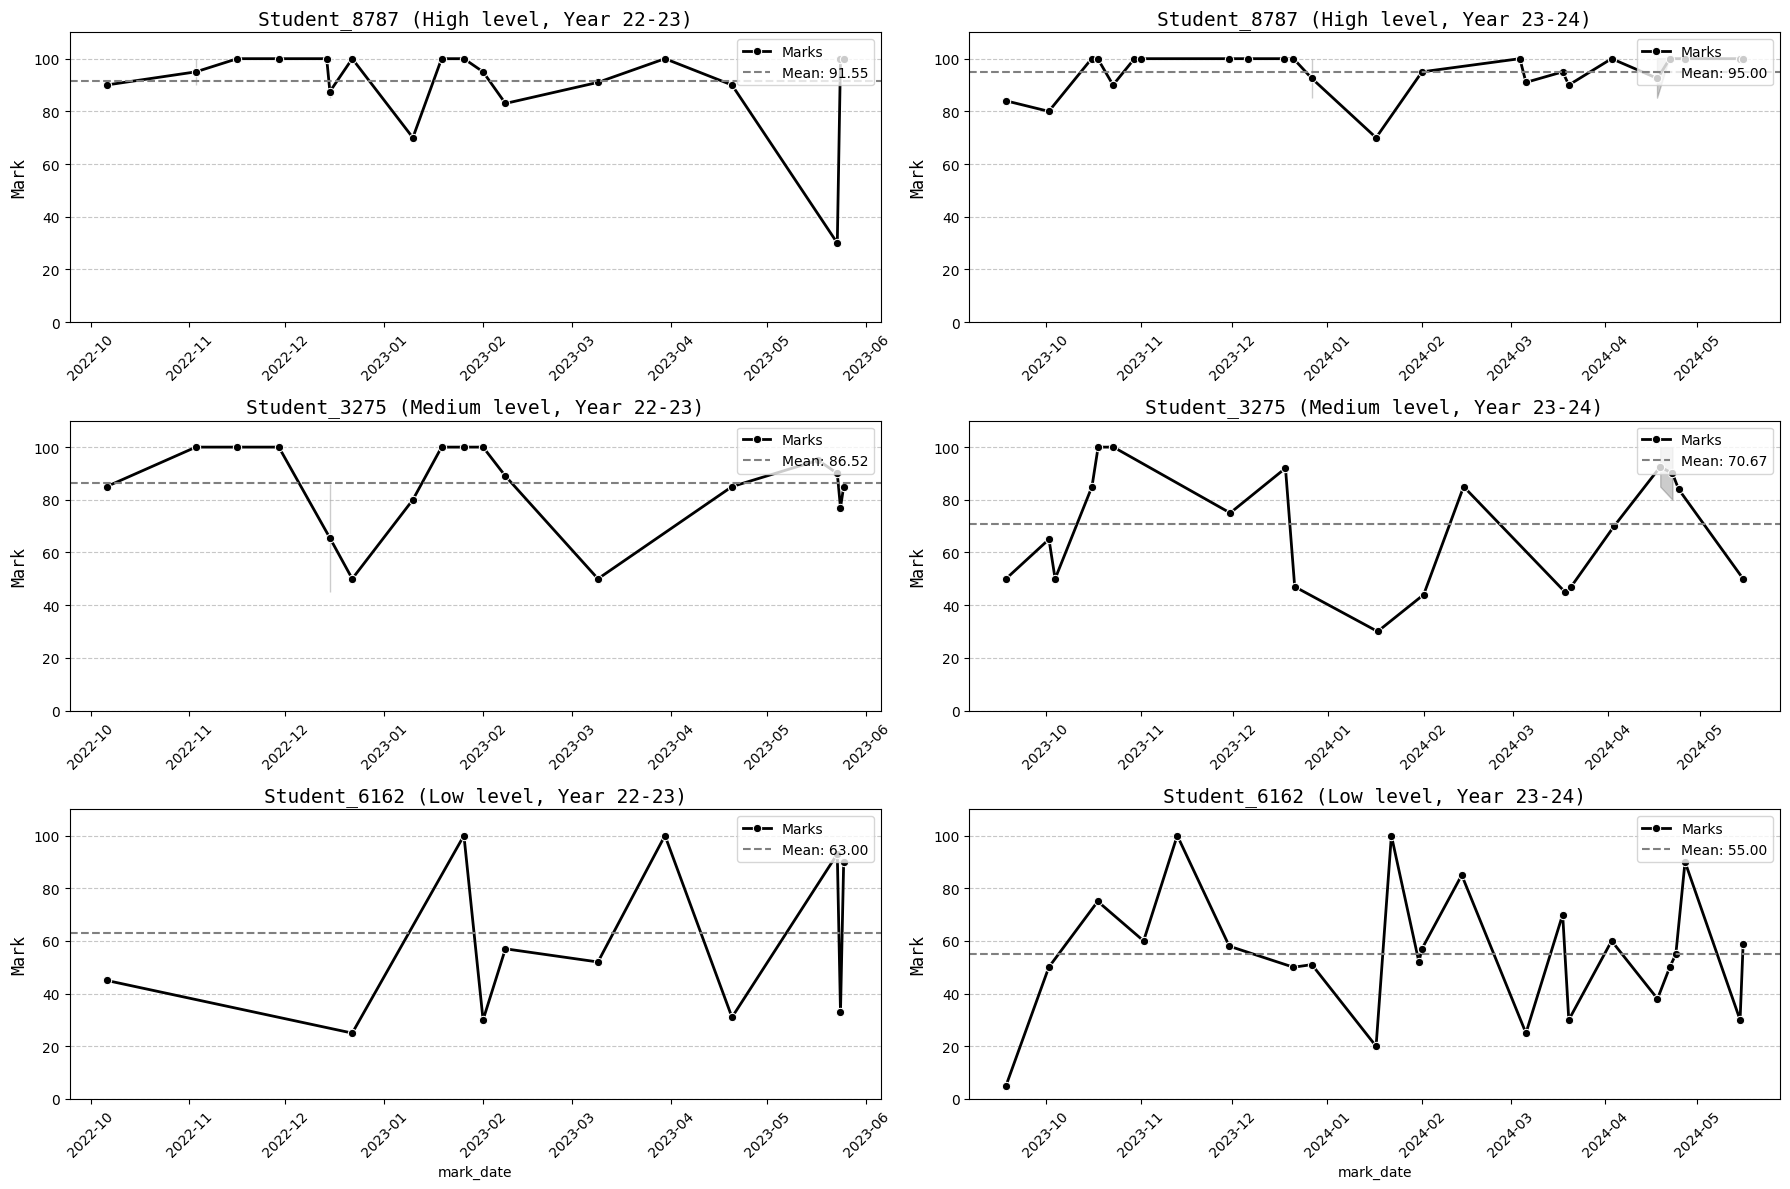

In [153]:
target_students = [
    ("Student_8787", "High"),
    ("Student_3275", "Medium"),
    ("Student_6162", "Low"),
]

year_22_23 = (pd.Timestamp("2022-09-01"), pd.Timestamp("2023-05-31"))
year_23_24 = (pd.Timestamp("2023-09-01"), pd.Timestamp("2024-05-31"))

plt.figure(figsize=(18, 12))

for i, (student_id, grade_level) in enumerate(target_students, 1):
    target_df = get_student_series_of_math_grades(main_df, student_id)

    year_df_22_23 = target_df[
        (target_df["mark_date"] >= year_22_23[0])
        & (target_df["mark_date"] <= year_22_23[1])
    ]
    year_df_23_24 = target_df[
        (target_df["mark_date"] >= year_23_24[0])
        & (target_df["mark_date"] <= year_23_24[1])
    ]

    plt.subplot(len(target_students), 2, 2 * i - 1)
    sns.lineplot(
        data=year_df_22_23,
        x="mark_date",
        y="mark",
        marker="o",
        linewidth=2,
        label="Marks",
        color="black",
    )

    if not year_df_22_23.empty:
        avg_mark = year_df_22_23["mark"].mean()
        plt.axhline(
            avg_mark,
            color="gray",
            linestyle="--",
            label=f"Mean: {avg_mark:.2f}",
        )

    plt.ylim(0, 110)
    plt.title(
        f"{student_id} ({grade_level} level, Year 22-23)",
        fontsize=14,
        fontfamily="monospace",
    )

    plt.ylabel("Mark", fontsize=12, fontfamily="monospace")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend(loc="upper right", bbox_to_anchor=(1, 1), fontsize=10)

    if i != len(target_students):
        plt.xlabel(None)

    plt.subplot(len(target_students), 2, 2 * i)
    sns.lineplot(
        data=year_df_23_24,
        x="mark_date",
        y="mark",
        marker="o",
        linewidth=2,
        label="Marks",
        color="black",
    )

    if not year_df_23_24.empty:
        avg_mark = year_df_23_24["mark"].mean()
        plt.axhline(
            avg_mark,
            color="gray",
            linestyle="--",
            label=f"Mean: {avg_mark:.2f}",
        )

    plt.ylim(0, 110)
    plt.title(
        f"{student_id} ({grade_level} level, Year 23-24)",
        fontsize=14,
        fontfamily="monospace",
    )

    plt.ylabel("Mark", fontsize=12, fontfamily="monospace")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend(loc="upper right", bbox_to_anchor=(1, 1), fontsize=10)

    if i != len(target_students):
        plt.xlabel(None)

plt.tight_layout()
plt.savefig("figures/mark_time_series.png")

In [ ]:
for student_id, level in target_students:
    target_df = get_student_series_of_math_grades(main_df, student_id)

    year_df_22_23 = target_df[
        (target_df["mark_date"] >= year_22_23[0])
        & (target_df["mark_date"] <= year_22_23[1])
    ]
    year_df_23_24 = target_df[
        (target_df["mark_date"] >= year_23_24[0])
        & (target_df["mark_date"] <= year_23_24[1])
    ]

    print(
        f"2022-2023 grade dispersion for student ({student_id}) with {level} level ({target_df["mark"].mean().round(2)}):",  # noqa: E501
        year_df_22_23["mark"].var().round(2),
    )
    print(
        f"2023-2024 grade dispersion for student ({student_id}) with {level} level ({target_df["mark"].mean().round(2)}):",  # noqa: E501
        year_df_23_24["mark"].var().round(2),
    )
    print("----------")

2022-2023 grade dispersion for student (Student_8787) with High level (93.45): 249.88
2023-2024 grade dispersion for student (Student_8787) with High level (93.45): 63.92
----------
2022-2023 grade dispersion for student (Student_3275) with Medium level (78.6): 312.86
2023-2024 grade dispersion for student (Student_3275) with Medium level (78.6): 512.73
----------
2022-2023 grade dispersion for student (Student_6162) with Low level (57.67): 970.36
2023-2024 grade dispersion for student (Student_6162) with Low level (57.67): 572.52
----------
